In [1]:
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, roc_curve, auc, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from xgboost import plot_importance
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline

# Data Load

In [2]:
train = pd.read_csv("data/train_distance_geohash_airports_neighborhoods_weather.csv", index_col=0)

/Users/mgouy/Documents/pydev/ENV/lib/python2.7/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
train.head()

,start_lng,start_lat,end_lng,end_lat,start_timestamp,duration,distance,start_geohash,end_geohash,laguardia,...,dr5rs,dr5rt,dr5rw,timestamp,month,dow,hour,date,rain,snow
0,-74.009087,40.713818,-74.004326,40.719986,1420950819,112,794,dr5reg,dr5reu,0,...,0,0,0,2015-01-11 04:33:39,1,6,4,2015-01-11,0,0
1,-73.971176,40.762428,-74.004181,40.742653,1420950819,1159,3548,dr5rus,dr5rgb,0,...,0,0,0,2015-01-11 04:33:39,1,6,4,2015-01-11,0,0
2,-73.974030,40.763126,-74.002647,40.760700,1420945942,674,2431,dr5rus,dr5ruh,0,...,0,0,0,2015-01-11 03:12:22,1,6,3,2015-01-11,0,0
3,-73.983643,40.764511,-74.001961,40.735809,1420945943,1210,3542,dr5ruk,dr5rsp,0,...,1,0,0,2015-01-11 03:12:23,1,6,3,2015-01-11,0,0
4,-74.008125,40.703854,-73.985641,40.760357,1420947429,1474,6555,dr5rec,dr5ruk,0,...,0,0,0,2015-01-11 03:37:09,1,6,3,2015-01-11,0,0


In [4]:
train.shape

(12905715, 38)

In [79]:
# Let's extract a random sample of the data for faster iterations
train_sample = train.sample(50000, random_state=157)

# EDA

### Any null value?

In [35]:
train.columns[train.isnull().any()].tolist()

[]

### Distribution of durations

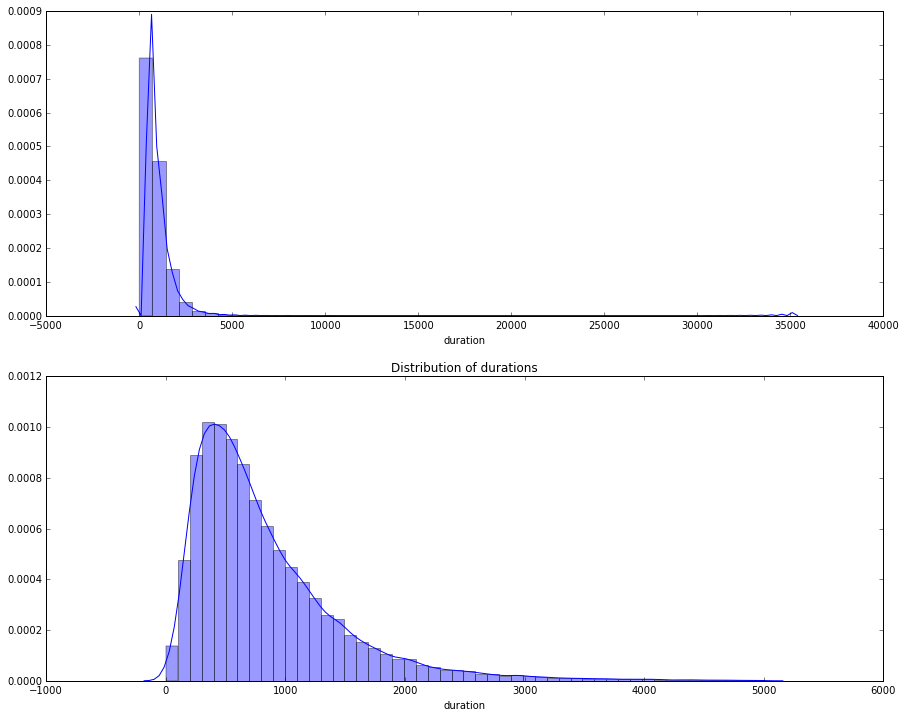

In [24]:
f, (ax1, ax2) = plt.subplots(2, figsize=(15,12))
plt.title('Distribution of durations')
plt.xlabel('trip duration [s]')
sns.distplot(train_sample.duration, ax=ax1)
sns.distplot(train_sample[train_sample.duration < 5000].duration)
plt.show()

Most trips have a duration < 5000s (~1h30min) we observe some outliers with durations over 9hrs. Are those outliers legitimate (just very long rides) or are they anomalies?

#### Long durations

In [16]:
train[train.duration > 30000].head()

,start_lng,start_lat,end_lng,end_lat,start_timestamp,duration,distance,start_geohash,end_geohash,laguardia,...,dr5rs,dr5rt,dr5rw,timestamp,month,dow,hour,date,rain,snow
36829,-73.873688,40.773979,-73.986237,40.750359,1421013478,36122,9858,dr5ryy,dr5ru6,1,...,0,0,0,2015-01-11 21:57:58,1,6,21,2015-01-11,0,0
87511,-73.888596,40.758793,-74.039131,40.730282,1422219276,39924,13102,dr5rye,dr5ren,0,...,0,0,0,2015-01-25 20:54:36,1,6,20,2015-01-25,0,0
90077,-73.783653,40.648769,-73.992805,40.713112,1422224158,35042,19070,dr5x1p,dr5rs7,0,...,1,0,0,2015-01-25 22:15:58,1,6,22,2015-01-25,0,0
106362,-73.946259,40.777187,-73.979790,40.755127,1422227794,35381,3743,dr5rvr,dr5rue,0,...,0,0,0,2015-01-25 23:16:34,1,6,23,2015-01-25,0,0
107665,-73.780090,40.647243,-73.989548,40.758186,1422223681,35519,21566,dr5x1p,dr5ru7,0,...,0,0,0,2015-01-25 22:08:01,1,6,22,2015-01-25,0,0


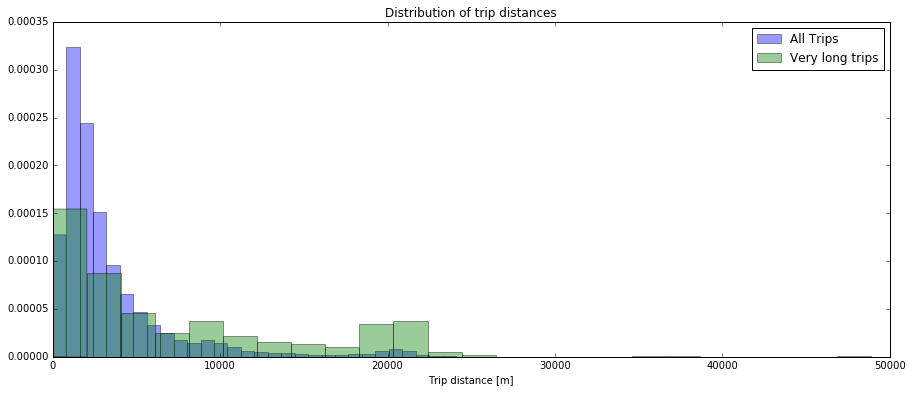

In [33]:
plt.subplots(figsize=(15,6))
plt.title('Distribution of trip distances')
sns.distplot(train_sample.distance, norm_hist=True, kde=False, label="All Trips")
sns.distplot(train[train.duration > 20000].distance, norm_hist=True, kde=False, label="Very long trips")
plt.xlabel('Trip distance [m]')
plt.legend(['All Trips', 'Very long trips'], loc='upper right')
plt.show()

The distribution of distances for very long trips is not very skewed compared to the distribution of all trips. Therefore, those very long trips are likely to be anomalies and we will discard them when training. Indeed, those kind of outliers can negatively impact the model performance, especially if the latter optimizes to minimize the mse.

Something worth noting in the plot above is the small spike aroud 20km, which is likely caused by the airports trips 

#### Short durations

In [97]:
train_sample[train_sample.duration < 60][['distance']].describe()

,distance
count,293.000000
mean,119.863481
std,184.589164
min,0.000000
25%,0.000000
50%,22.000000
75%,172.000000
max,1325.000000


They seem to be mostly caused by very short trips (bug caused by app of riders/drivers), so nothing anomalous there.

# Train/Test sets Preparation

In [109]:
train_sample = train.sample(50000, random_state=157)
train_sample = train_sample[train_sample.duration < 20000]
train_sample = pd.get_dummies(train_sample, columns=['month', 'dow'])
cols = set(train_sample.columns)

exclude = set(['start_lng',
 'start_lat',
 'end_lng',
 'end_lat',
 'start_timestamp',
 'duration',
 'start_geohash',
 'end_geohash',
 'timestamp',
 'date'])

features = list(cols - exclude)

In [110]:
features

['dr5ry',
 'month_12',
 'dr5rs',
 'dr5rt',
 'dr5ru',
 'dr5rv',
 'dr5rw',
 'dr724',
 'dow_2',
 'dow_3',
 'dow_0',
 'dow_1',
 'dow_6',
 'dr5re',
 'dr5rf',
 'dr5rg',
 'dr5rd',
 'dr726',
 'dr727',
 'month_10',
 'dr725',
 'month_4',
 'month_5',
 'month_6',
 'month_11',
 'month_7',
 'month_2',
 'month_3',
 'dow_5',
 'month_8',
 'month_9',
 'month_1',
 'rain',
 'dow_4',
 'jfk',
 'distance',
 'hour',
 'laguardia',
 'snow',
 'dr72q',
 'dr72j',
 'dr72k',
 'dr72h',
 'dr72n',
 'dr72m']

In [111]:
X = np.array(train_sample[features])
Y = np.array(train_sample[['duration']])

In [112]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=158)

# Models

## Linear Regression

We first start by training a simple linear regression to get a baseline performance

In [39]:
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

/Users/mgouy/Documents/pydev/ENV/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


In [40]:
lr = LinearRegression()

In [98]:
lr.fit(X_train_norm, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [99]:
y_pred_lr = lr.predict(X_test_norm)

In [100]:
mean_absolute_error(y_test, y_pred_lr)

282.92528515625003

## XGBoost

### XGBoost out of the box

In [113]:
xgb_regressor = xgb.XGBRegressor(n_estimators=600, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=6)

In [114]:
eval_set = [(X_test, y_test)]
xgb_regressor.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="mae", eval_set=eval_set, verbose=True)

[0]	validation_0-mae:773.769
Will train until validation_0-mae hasn't improved in 30 rounds.
[1]	validation_0-mae:712.294
[2]	validation_0-mae:655.817
[3]	validation_0-mae:603.896
[4]	validation_0-mae:556.628
[5]	validation_0-mae:513.493
[6]	validation_0-mae:474.562
[7]	validation_0-mae:439.393
[8]	validation_0-mae:408.484
[9]	validation_0-mae:381.475
[10]	validation_0-mae:357.931
[11]	validation_0-mae:337.394
[12]	validation_0-mae:319.938
[13]	validation_0-mae:305.081
[14]	validation_0-mae:292.615
[15]	validation_0-mae:282.135
[16]	validation_0-mae:273.315
[17]	validation_0-mae:265.834
[18]	validation_0-mae:259.72
[19]	validation_0-mae:254.598
[20]	validation_0-mae:250.385
[21]	validation_0-mae:246.932
[22]	validation_0-mae:244.25
[23]	validation_0-mae:241.897
[24]	validation_0-mae:239.974
[25]	validation_0-mae:238.47
[26]	validation_0-mae:237.246
[27]	validation_0-mae:236.285
[28]	validation_0-mae:235.575
[29]	validation_0-mae:235.113
[30]	validation_0-mae:234.646
[31]	validation_0-m

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.08, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=600,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.75)

In [115]:
y_pred = xgb_regressor.predict(X_test)

In [116]:
mean_absolute_error(y_test, y_pred)

228.7061599143982

The MAE is almost a minute less than for the simple logistic regression, let's spend a little bit of time tuning the xgboost hyper parameters

### Hyper Parameters Tuning using CV and GridSearch

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,20))
plot_importance(xgb_regressor, ax=ax)
plt.show()